## **Validación cruzada. Dev/hold-out. Optimización de hiperparámetros.**

En esta primera práctica de la clase nos enfocaremos en los tres temas enunciados en el título.

- - -

### `1. Validación cruzada`

A la hora de evaluar nuestro modelo, ¿cómo podemos garantizar que su desempeño es independiente de la separación de los datos que hayamos realizado?

La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que esos resultados sean independientes de la partición entre datos de entrenamiento y datos de testeo. Con esta técnica, a su vez, resulta más fácil detectar el overfitting.

Una de las formas más conocidas de emplear esta técnica es a través de **k-folds**. K refiere al número de grupos en los cuales se va a dividir la muestra de datos, convirtiéndose uno de ellos en set de prueba y los restantes grupos en set de entrenamiento. Luego, se itera.

El performance del modelo será el promedio de las K evaluaciones. También es importante considerar la desviación estándar.

<img src = "https://upload.wikimedia.org/wikipedia/commons/f/f2/K-fold_cross_validation.jpg">

Por el momento, veníamos utilizando una metodología que se asemejaría a la iteración 1 del gráfico supra. Del total de datos, dividíamos una parte en datos de prueba y otra en datos de entrenamiento. Pero esto se mantenía fijo ya que no iterábamos. 

Supongamos que tenemos un dataset con ciertos atributos $X$ y una variable de salida $y$. Cada instancia puede tener como valor de salida un 0 o un 1 -es decir, estamos frente a un problema de clasificación binaria-. Si hacemos un único train-test split, podría pasar que los subsets de entrenamiento y testeo sean muy heterogéneos entre sí pero muy homogéneos en su interior, fruto del azar de esa división. Para evitar esto, recurrimos a ***cross-validation***.

<img src = "https://upload.wikimedia.org/wikipedia/commons/1/18/Esquema_castell%C3%A0.jpg" height = 400>

Pasemos, ahora sí, a ver la implementación de esta técnica.

### Introduccion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Trabajaremos con un dataset provisto por scikit-learn de diagnóstico de cáncer.

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
# Lo convertimos a DataFrame

df = pd.DataFrame(np.c_[data['data'], data['target']],
                  columns= np.append(data['feature_names'], ['target']))

In [4]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


### Graficos

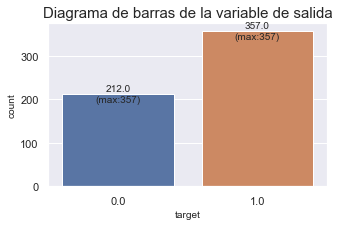

In [8]:
# Grafico la cantidad de valores negativos (0) y positivos (1) del target para ver si esta balanceado.
plt.figure(figsize=(4,3))
# sns.countplot(x = 'target' ,label= 'Count', data = df)
# Imprimo los valores maximos de cada barra
ax = sns.countplot(x='target', label='Count', data=df)
max_values = df.groupby(['target']).size().max() # Guardo los valores maximos de cada barra
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{p.get_height()}\n(max:{max_values})', ha='center', va='center')
    
plt.title('Diagrama de barras de la variable de salida', fontsize = 15)
plt.show()

0 = 37% de los valores de salida
1 = 63% de los valores de salida
Es posible que el modelo se sesgue hacia el 1 si no se hace un balanceo previo.

In [9]:
# Nos quedamos solamente con los primeros 10 atributos para simplificar el proceso

features_mean = list(df.columns[0:10])
features_mean

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension']

In [10]:
# Agregamos la variable de salida

df = df[features_mean + ['target']]
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.0


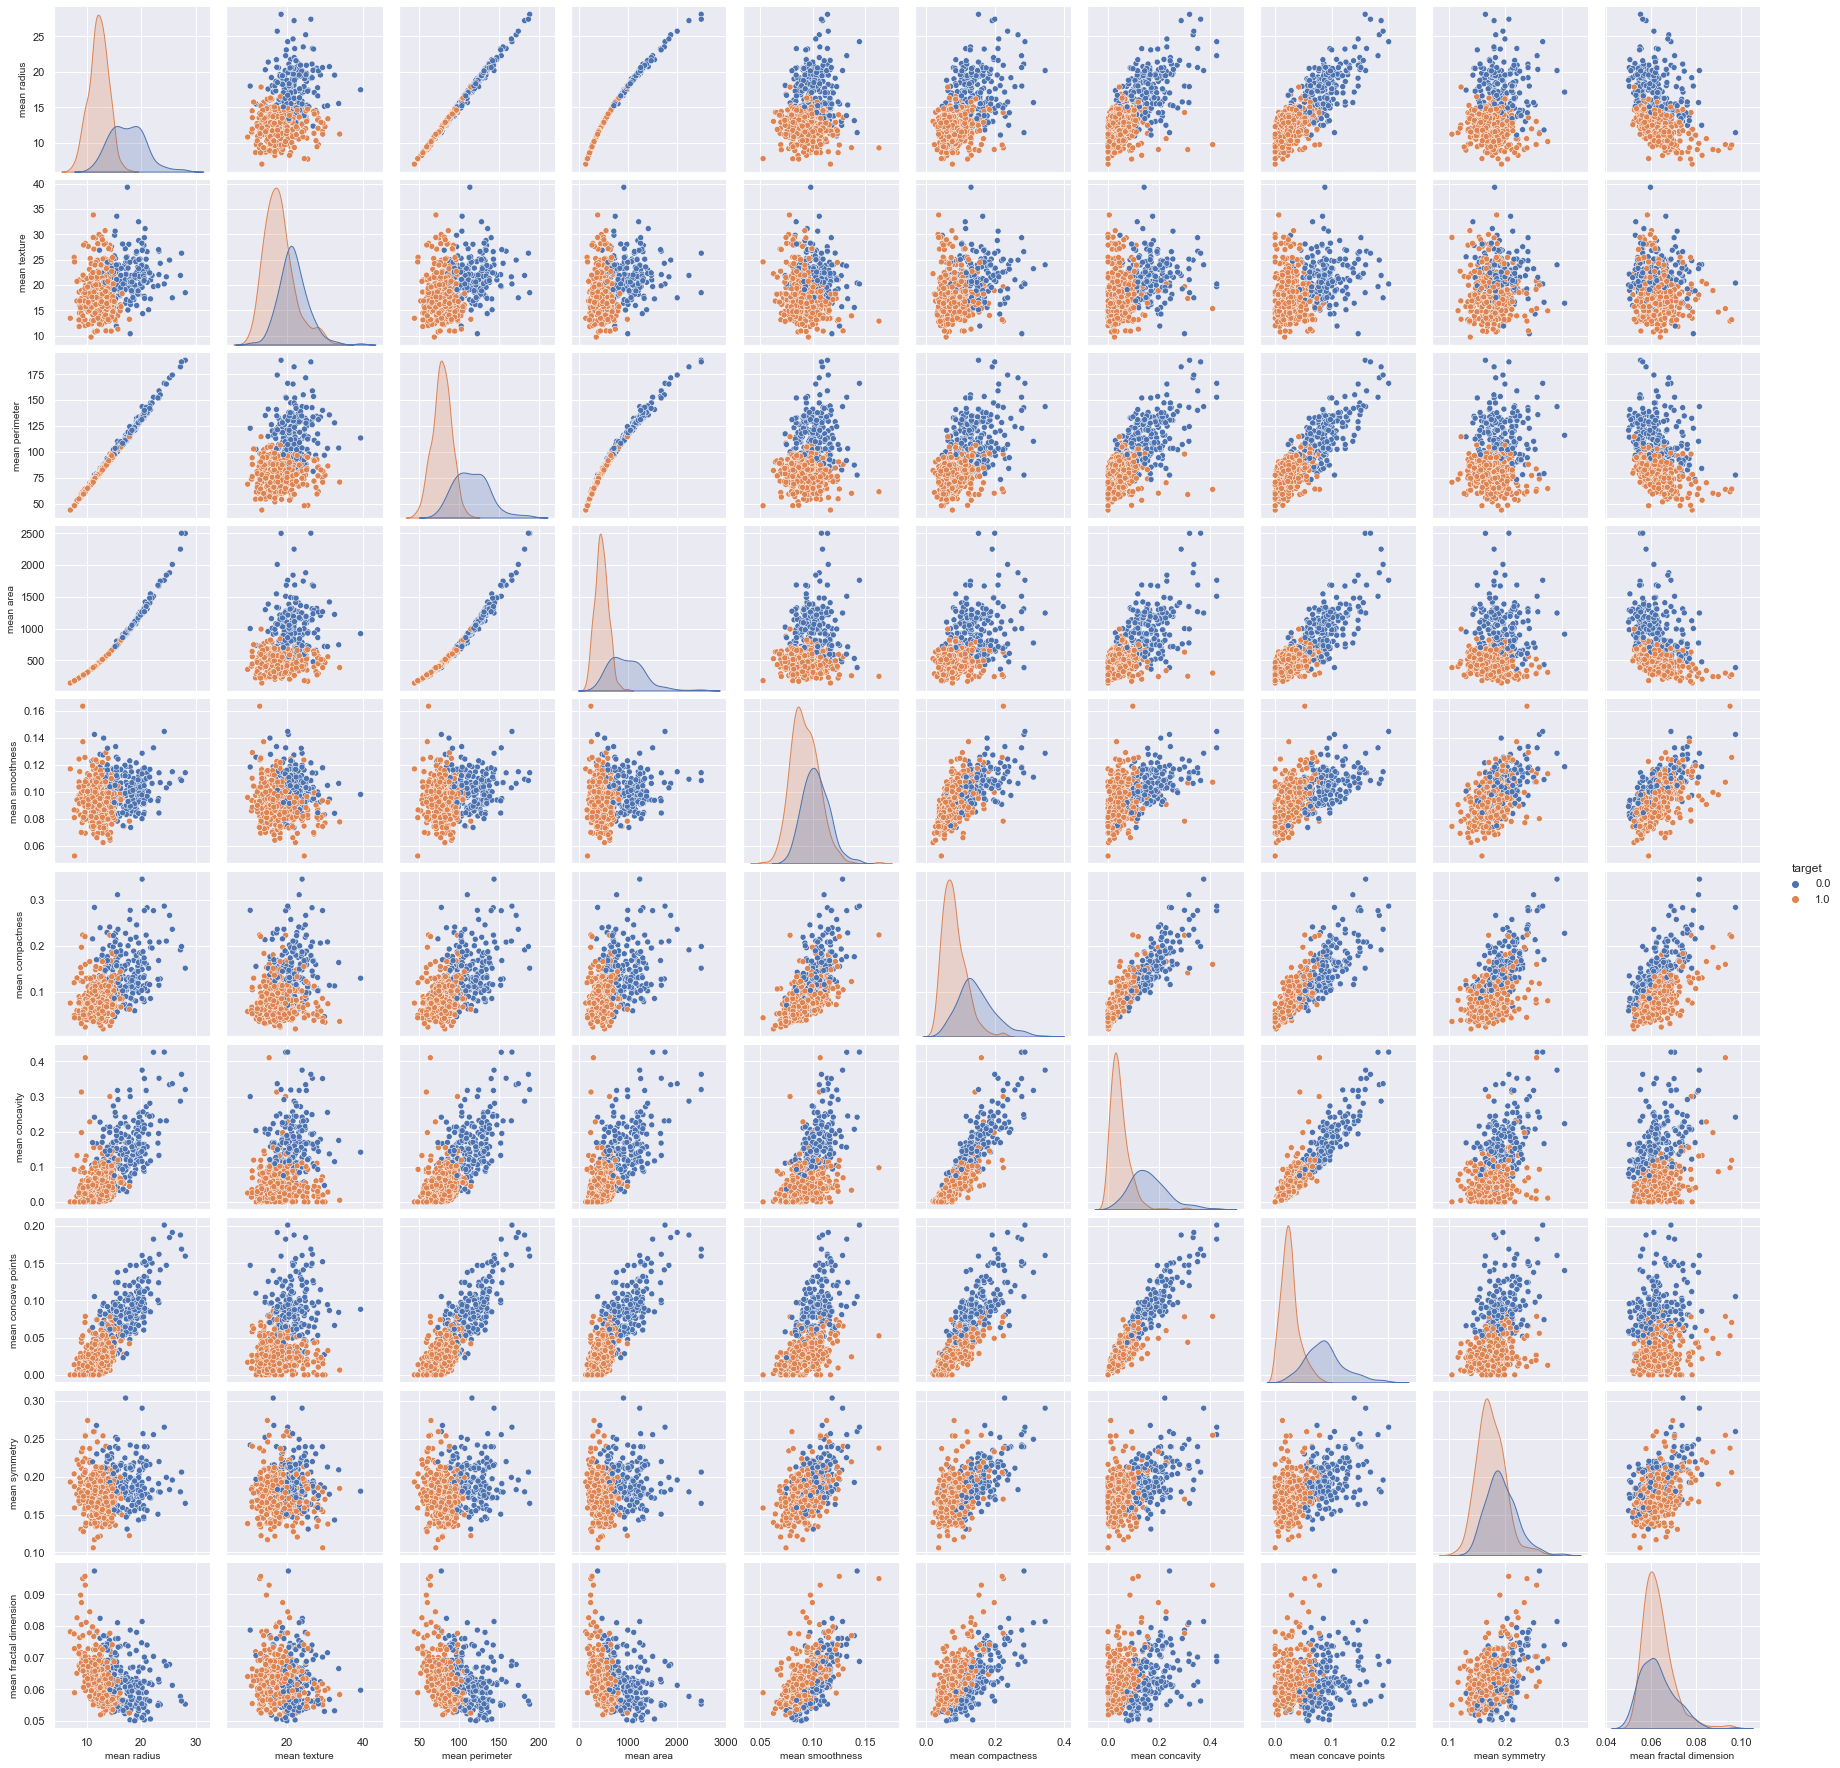

In [11]:
# Hacemos un pairplot

sns.pairplot(df, hue = 'target')
plt.show()

La columna 1, 3 y 4 parecen ser redundantes, ya que mean perimeter y mean area dependen directamente de mean radius.
En menor medida puede haber redundanica entre 7 y 8.

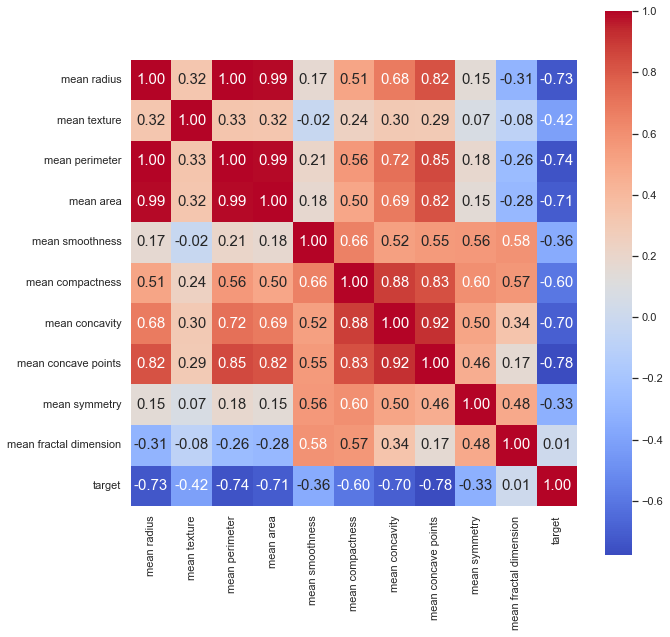

In [15]:
# Realizamos el mapa de calor para ver la correlación entre las variables

corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.columns, 
           yticklabels= df.columns,
           cmap= 'coolwarm')
plt.show()

Solo se observan correlaciones lineales negativas significativas. 
Destaca la columna 8 (mean concave points) con -0.78, pudiendo eliminarse la columna 7.
Dada la redundancia, se pueden descartar la columna 3 y 4, quedando la 1 (mean radius) con correlacion -0.73.
Conclusion: Eliminar 3, 4 y 7. Destacar 1 y 8.

### Entrenamiento de los modelos

Vamos a entrenar un árbol profundidad infinita y un modelo K-NN con un vecino. Los vamos a entrenar y evaluar haciendo un `train_test_split`, dejando un 10% de los datos para testeo.

In [12]:
# Seleccionamos las variables predictoras X y la variable a predecir y

X = df[['mean radius','mean smoothness', 'mean concave points']]
y = df['target']

In [13]:
# Realizamos un escalado de los datos. 
# Esto se debe a que K-NN trabaja con distancias y no puede discernir la diferencia de escala y unidades entre cada una de las variables.
# Al escalar y normalizar los datos con StandardScaler, se transforman las características para que tengan una media de cero y una varianza de uno. 
# Asegura que las características tengan una escala comparable, mejora la precisión del modelo K-NN al reducir la influencia de las características 
# que tienen valores atípicos o varían en diferentes escalas.

from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X = scl.fit_transform(X)

In [14]:
y.sum()/y.count()

0.6274165202108963

Luego de la normalizacion con StandardScaler, la proprcion de 1 sigue siendo del 63% en el target.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=60, stratify=y)

In [16]:
print('Proporción de etiquetas en set de entrenamiento:', y_train.sum()/y_train.count())
print('Proporción de etiquetas en set de testeo:', y_test.sum()/y_test.count())

Proporción de etiquetas en set de entrenamiento: 0.626953125
Proporción de etiquetas en set de testeo: 0.631578947368421


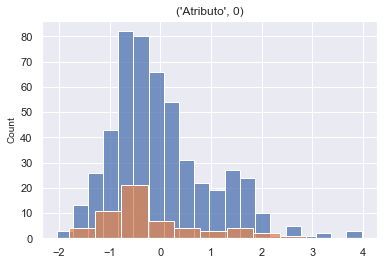

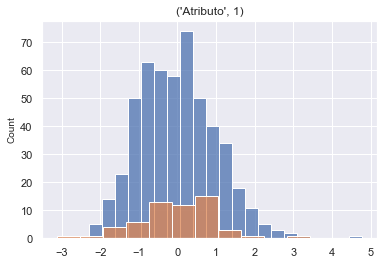

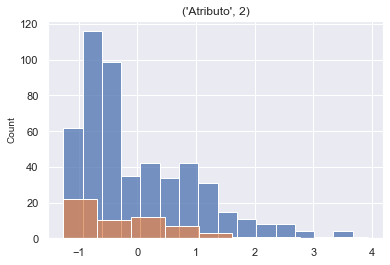

In [18]:
# Chequeamos la distribución de los subsets

for i in range(X_train.shape[1]):
    sns.histplot(x = X_train[:,i])
    sns.histplot(x = X_test[:,i])
    titulo = 'Atributo', i
    plt.title(titulo)
    plt.show()

*Probar qué sucede si no especificamos el argumento **stratify** en train_test_split*.

In [19]:
print('Proporción de etiquetas positiva en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporción de etiquetas positiva en los datos de Test: ', y_test.sum()/y_test.size)

Proporción de etiquetas positiva en los datos de Train:  0.626953125
Proporción de etiquetas positiva en los datos de Test:  0.631578947368421


### Prueba sin stratify
La estratificación es importante cuando se trabaja con un conjunto de datos desequilibrado, es decir, cuando hay una gran diferencia en el número de muestras en cada clase. En tales casos, es importante asegurarse de que las proporciones de cada clase se mantengan en ambos conjuntos, de entrenamiento y prueba, para evitar la subrepresentación o sobre-representación de alguna clase.

Por ejemplo, si un conjunto de datos tiene 100 muestras, de las cuales 80 pertenecen a la clase A y 20 pertenecen a la clase B, si se realiza una división aleatoria simple, puede ocurrir que la mayoría de las muestras de la clase B terminen en el conjunto de prueba, lo que resultaría en un conjunto de entrenamiento con una gran cantidad de muestras de la clase A y muy pocas de la clase B. Esto puede resultar en una pobre generalización del modelo para la clase B.

Al utilizar el parámetro stratify, se garantiza que los conjuntos de entrenamiento y prueba mantengan las mismas proporciones de clases que el conjunto de datos original. Es decir, la proporción de muestras en cada clase se mantendrá en ambos conjuntos. Esto es particularmente útil en problemas de clasificación, donde la proporción de muestras en cada clase es importante para lograr una buena precisión y recall.

Por lo tanto, al utilizar stratify en train_test_split, se asegura que los conjuntos de entrenamiento y prueba sean representativos del conjunto de datos original, lo que ayuda a mejorar la precisión del modelo y su capacidad para generalizar a nuevos datos.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=60)
print('Proporción de etiquetas en set de entrenamiento:', y_train.sum()/y_train.count())
print('Proporción de etiquetas en set de testeo:', y_test.sum()/y_test.count())

Proporción de etiquetas en set de entrenamiento: 0.623046875
Proporción de etiquetas en set de testeo: 0.6666666666666666


### Arbol de decision

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# Instanciamos el árbol
# se crea un objeto DecisionTreeClassifier con la opción max_depth=None, lo que significa que no hay restricciones en la profundidad del árbol. 
# Luego, se ajusta este modelo con los datos de entrenamiento X_train e y_train utilizando el método fit().

tree = DecisionTreeClassifier(max_depth = None)
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
# Predecimos sobre nuestro set de entrenamiento

y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de test

y_test_pred = tree.predict(X_test)

# Comparamos con las etiquetas reales

print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.9122807017543859


### K-Vecinos mas cercanos

In [24]:
# Instanciamos un modelo de vecinos más cercanos
# se crea un objeto KNeighborsClassifier con un parámetro n_neighbors igual a 1, lo que significa que el modelo considera solo el vecino más cercano. 
# Este modelo también se ajusta utilizando el método fit().
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [25]:
# Predecimos sobre nuestro set de entrenamiento

y_train_pred = knn.predict(X_train)

# Predecimos sobre nuestro set de test

y_test_pred = knn.predict(X_test)

# Comparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 1.0
Accuracy sobre conjunto de Test: 0.8947368421052632


***Para corroborar la incidencia de la división de los datos, modificar el valor de random_state a la hora de hacer train_test_split y correr todo de nuevo.***

### Validacion cruzada

In [26]:
# Importamos cross_val_score 
# Se importa la función cross_val_score desde la biblioteca sklearn.model_selection, que permite realizar validación cruzada en los datos de entrada.
from sklearn.model_selection import cross_val_score

In [27]:
# Se utilizan los modelos de árboles de decisión y k-NN ajustados previamente para calcular los puntajes de validación cruzada 
# utilizando el conjunto de datos X e y, con cv=5 que indica utilizar validación cruzada con 5 folds.
# Los resultados de la validación cruzada se almacenan en las variables tree_scores y knn_scores, respectivamente.
tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X, y, cv=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn_scores = cross_val_score(knn, X, y, cv=5)

In [28]:
# Muestra el resultado de cada uno de los 5 folds
print(tree_scores)
print(knn_scores)

[0.86842105 0.90350877 0.92105263 0.9122807  0.85840708]
[0.87719298 0.88596491 0.87719298 0.92105263 0.89380531]


In [29]:
print("Accuracy para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))
print("Accuracy para KNN: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

Accuracy para Tree: 0.89 (+/- 0.05)
Accuracy para KNN: 0.89 (+/- 0.03)


In [30]:
# Ahora probamos con cross_validate. Esta función brinda un poco más de información

from sklearn.model_selection import cross_validate

In [31]:
tree_scores = cross_validate(tree, X, y, cv=5, scoring = ['precision','recall'])
knn_scores = cross_validate(knn, X, y, cv=5, scoring = ['precision','recall'])

In [32]:
print(tree_scores)

{'fit_time': array([0.00500512, 0.0022893 , 0.00241303, 0.00670385, 0.00239205]), 'score_time': array([0.00705814, 0.01884389, 0.00418591, 0.00881791, 0.00690198]), 'test_precision': array([0.87837838, 0.87179487, 0.95652174, 0.91666667, 0.96666667]), 'test_recall': array([0.91549296, 0.95774648, 0.91666667, 0.91666667, 0.81690141])}


In [33]:
print(knn_scores)

{'fit_time': array([0.00169992, 0.0032599 , 0.01018476, 0.00121021, 0.00465012]), 'score_time': array([0.0140841 , 0.02639818, 0.018188  , 0.02483678, 0.02443194]), 'test_precision': array([0.89041096, 0.88157895, 0.90277778, 0.94366197, 0.94029851]), 'test_recall': array([0.91549296, 0.94366197, 0.90277778, 0.93055556, 0.88732394])}


In [34]:
# Observemos todas las métricas que podemos usar para evaluar nuestros modelos

import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

- - -

### `2. Dev/hold-out`

Para optimizar hiperparámetros, que es el tercer punto que tocaremos en este notebook, previamente tenemos que incorporar estos conceptos.

A la hora de evaluar modelos, debemos hacer un primer train-test split. De esta forma, nos quedamos con el subconjunto de test que utilizaremos al final para calcular cuál es el mejor modelo.

<img src = "https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png">


**Training set** será nuestro conjunto de desarrollo (dev). Aquí es donde haremos validación cruzada. En este conjunto, hacemos todas las pruebas que consideremos necesarias. Experimentamos con hiperparámetros. Evaluamos los modelos haciendo cross-validation.

Luego, elegimos un modelo a partir de este desempeño y lo evaluamos en **Test set**, que es nuestro conjunto **hold-out**.

- - -

### `3. Optimización de hiperparámetros`

Esta técnica se emplea para obtener el mejor modelo posible. Por supuesto, antes debemos elegir una métrica para comparar.

Existen tres estrategias para optimizar hiperparámetros -recordemos que son los parámetros de los modelos que define el datascientist antes de entrenar los modelos-:

+ Búsqueda manual: elegimos algunos hiperparámetros del modelo según nuestro criterio o experiencia previa. Es común probar con algunos valores a mano antes de pasar a algo más metódico. Esta estrategia resulta tediosa y poco eficiente.

+ Grid search: tomamos todos los hiperparámetros que queremos explorar y elegimos posibles valores. Luego, creamos un diccionario de hiperparámetros y entrenamos/validamos nuestro modelo en cada una de las combinaciones posibles. Posteriormente, elegimos la mejor combinación -el modelo con mejor performance según la métrica empleada-. Su principal inconveniente reside en que puede convertirse en un problema computacionalmente costoso. Cada modelo creado por grid search se evalúa con validación cruzada en el conjunto de Dev. Una vez elegidos los mejores hiperparámetros, debemos entrenar un modelo con esos hiperparámetros con todo el conjunto de Dev y evaluarlo en el conjunto de hold-out.

+ Random search: exploramos opciones y combinaciones al azar, a partir del diccionario creado. Luego entrenamos/validamos nuestro modelo con dichos valores y rescatamos aquel con mejor performance. Aquí se prueban menos combinaciones de hiperparámetros, pero más valores de cada uno de ellos. Esto se debe a que sampleamos en un rango de valores y no sobre una grilla regular.


Recalculando, para optimizar hiperparámetros necesitamos: una métrica, un modelo, un espacio de hiperparámetros y una estrategia.

Dejamos la documentación de [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) y de [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

### Grid search

In [35]:
# Continuamos con el dataset que estábamos usando

# Creamos la grilla de hiperparámetros para el modelo de vecinos más cercanos

param_grid = {'n_neighbors':np.arange(1, 20),
              'weights': ['uniform', 'distance'], 
              'leaf_size':[1,3,5,7,10],
              'algorithm':['auto', 'kd_tree']}

In [36]:
type(param_grid)

dict

In [37]:
# Instanciamos el modelo KNN

knn = KNeighborsClassifier()

In [38]:
# Probamos la estrategia grid search

from sklearn.model_selection import GridSearchCV

# Le pasamos la grilla que creamos
model = GridSearchCV(knn, param_grid=param_grid, cv=5)

# Entrenamos
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5, 7, 10],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']})

Existen tres variables que nos informan la mejor combinación, la mejor performance y los resultados: `best_params_`, `best_score_` y `cv_results_`.

In [39]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 6, 'weights': 'uniform'}
Mejor Score: 0.9121264039596422



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001829,0.000243,0.010259,0.003494,auto,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.912621,0.864078,0.862745,0.911765,0.892157,0.888673,0.021891,321
1,0.002305,0.000769,0.003598,0.001246,auto,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.912621,0.864078,0.862745,0.911765,0.892157,0.888673,0.021891,321
2,0.001953,0.000430,0.007505,0.002123,auto,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.864078,0.864078,0.862745,0.892157,0.882353,0.873082,0.011990,371
3,0.001628,0.000567,0.002025,0.000505,auto,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.912621,0.864078,0.862745,0.911765,0.892157,0.888673,0.021891,321
4,0.001338,0.000171,0.006405,0.000754,auto,1,3,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.883495,0.883495,0.833333,0.941176,0.892157,0.886731,0.034252,351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0.001576,0.000481,0.002066,0.000137,kd_tree,10,17,distance,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.941748,0.893204,0.872549,0.931373,0.901961,0.908167,0.025287,61
376,0.001243,0.000199,0.005953,0.000740,kd_tree,10,18,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.941748,0.893204,0.862745,0.921569,0.901961,0.904245,0.026668,231
377,0.001354,0.000298,0.002295,0.000454,kd_tree,10,18,distance,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.941748,0.893204,0.862745,0.941176,0.901961,0.908167,0.030142,61
378,0.001266,0.000310,0.005485,0.000352,kd_tree,10,19,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_n...",0.922330,0.883495,0.882353,0.931373,0.901961,0.904302,0.019890,191


In [40]:
#Predecimos en los datos de test con el mejor modelo obtenido
prediction = model.predict(X_test)

In [41]:
# Matriz de Confusion

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test,prediction)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[17  2]
 [ 4 34]]


In [42]:
print('Exactitud:', accuracy_score(y_test, prediction))

Exactitud: 0.8947368421052632


In [43]:
# Reporte de Clasificacion

from sklearn.metrics import classification_report

report = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85        19
         1.0       0.94      0.89      0.92        38

    accuracy                           0.89        57
   macro avg       0.88      0.89      0.88        57
weighted avg       0.90      0.89      0.90        57



### Random search

Ahora probemos la estrategia `random search`.

In [47]:
# Grilla para random search

import scipy as sp
from scipy import stats

param_dist = {'n_neighbors':sp.stats.randint(1, 20),
              'weights': ['uniform', 'distance'], 
              'leaf_size':sp.stats.randint(1, 10),
              'algorithm':['auto', 'kd_tree']}

In [48]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, param_dist,n_iter=100, random_state=0, cv=5)

# Entrenamos knn con la grilla
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x127081d20>,
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x127aa0d60>,
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [49]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

# Mejores hiperparámetros: {'algorithm': 'kd_tree', 'leaf_size': 7, 'n_neighbors': 14, 'weights': 'distance'}
# Mejor Score: 0.9315629164287074

Mejores hiperparámetros: {'algorithm': 'kd_tree', 'leaf_size': 1, 'n_neighbors': 6, 'weights': 'uniform'}
Mejor Score: 0.9121264039596422



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003436,0.001641,0.004822,0.003184,auto,6,1,distance,"{'algorithm': 'auto', 'leaf_size': 6, 'n_neigh...",0.912621,0.864078,0.862745,0.911765,0.892157,0.888673,0.021891,81
1,0.002301,0.000606,0.004859,0.001455,kd_tree,4,8,distance,"{'algorithm': 'kd_tree', 'leaf_size': 4, 'n_ne...",0.922330,0.902913,0.862745,0.931373,0.901961,0.904264,0.023631,53
2,0.005454,0.006369,0.011271,0.003019,kd_tree,6,19,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 6, 'n_ne...",0.922330,0.883495,0.882353,0.931373,0.901961,0.904302,0.019890,47
3,0.001735,0.000573,0.007783,0.001158,kd_tree,7,13,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.932039,0.883495,0.872549,0.941176,0.901961,0.906244,0.026672,31
4,0.001653,0.000554,0.002984,0.000771,kd_tree,7,8,distance,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.922330,0.902913,0.862745,0.931373,0.901961,0.904264,0.023631,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001982,0.000527,0.003391,0.000994,auto,6,12,distance,"{'algorithm': 'auto', 'leaf_size': 6, 'n_neigh...",0.932039,0.912621,0.872549,0.921569,0.901961,0.908148,0.020379,27
96,0.002168,0.000463,0.004423,0.000472,auto,3,14,distance,"{'algorithm': 'auto', 'leaf_size': 3, 'n_neigh...",0.932039,0.893204,0.882353,0.921569,0.901961,0.906225,0.018218,35
97,0.001870,0.000493,0.002828,0.000563,kd_tree,7,11,distance,"{'algorithm': 'kd_tree', 'leaf_size': 7, 'n_ne...",0.922330,0.912621,0.852941,0.911765,0.901961,0.900324,0.024553,71
98,0.002327,0.000906,0.008545,0.001223,auto,1,4,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.873786,0.883495,0.843137,0.941176,0.901961,0.888711,0.032419,77


In [50]:
#Predecimos en los datos de test

prediction = model.predict(X_test)

In [51]:
# Matriz de Confusion

cm = confusion_matrix(y_test,prediction)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[17  2]
 [ 4 34]]


In [52]:
# Reporte de Clasificacion
report = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85        19
         1.0       0.94      0.89      0.92        38

    accuracy                           0.89        57
   macro avg       0.88      0.89      0.88        57
weighted avg       0.90      0.89      0.90        57

